In [2]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read words ✅
# build vocabulary stoi, itos ✅
# build dataset with block_size (context_length) ✅
# construct training, dev, test set ✅
# create network - save parameters - count the number of parameters
# train with 20 epochs with loss printed in every epoch
# Show the training and dev loss
# print the embedding matrix
# sample from model
# add batching and see loss

In [4]:
names = open("../makemore/names.txt").read().splitlines()


In [5]:
all_chars = sorted(list(set(''.join(names))))
itos = {}
for i, c in enumerate(all_chars): 
    itos[i + 1] = c
    
itos[0] = '.'

In [6]:
stoi = {}
for i, c in itos.items(): 
    stoi[c] = i

In [7]:
block_size = 3
x, y = [], []
for word in names[:1]: 
    context = [0] * block_size
    for c in list(word) + ['.']: 
        x.append(context)
        y.append(stoi[c])
        context = context[1:] + [stoi[c]]
    

In [8]:
import torch        
X = torch.tensor(x)
Y = torch.tensor(y)
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([5, 3]), torch.Size([5]), torch.int64, torch.int64)

In [9]:
block_size = 3
def build_dataset(words): 
    x, y = [], []
    for word in words: 
        context = [0] * block_size
        for c in list(word) + ['.']: 
            x.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(f"{X.shape, Y.shape}")
    return X,Y



In [10]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

print(n1, n2)

25626 28829


In [11]:

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

(torch.Size([182625, 3]), torch.Size([182625]))
(torch.Size([22655, 3]), torch.Size([22655]))
(torch.Size([22866, 3]), torch.Size([22866]))


In [12]:
Xtr.shape

torch.Size([182625, 3])

In [13]:
# examples x 3 x 2
import torch.nn.functional as F
x_enc = F.one_hot(Xtr, num_classes=27).float()
x_enc.shape


torch.Size([182625, 3, 27])

In [14]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)


In [15]:
X.shape

torch.Size([5, 3])

In [16]:
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

In [17]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [18]:
h = torch.tanh(emb.view(-1 , 6) @ W1 + b1)

In [19]:
h.shape

torch.Size([5, 100])

In [20]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([5, 27])

In [23]:
counts = logits.exp()

In [24]:
prob = counts / counts.sum(dim=1, keepdim=True)
prob.shape

torch.Size([5, 27])

In [25]:
loss = -prob[torch.arange(5), Y].log().mean()

In [26]:
loss

tensor(25.4652)

In [27]:
# Let's go another attempt

In [28]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [40]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # 5 x 3 x 10
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


In [41]:
for p in parameters: 
    p.requires_grad = True

In [ ]:
epochs = 10000
stepsi = []
lossi = []
for i in range(epochs): 
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    xenc = C[Xtr[ix]] # 5 x 3 x 10 
    
    h = torch.tanh(xenc.view((-1 , 30)) @ W1 + b1)
    logits = h @ W2 + b2 
    counts = logits.exp()
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    lr = 0.01 
    for p in parameters: 
        p.data += -lr * p.grad
    
    
    stepsi.append(i)
    lossi.append(loss.item())

In [43]:
loss

tensor(2.3924, grad_fn=<NllLossBackward0>)

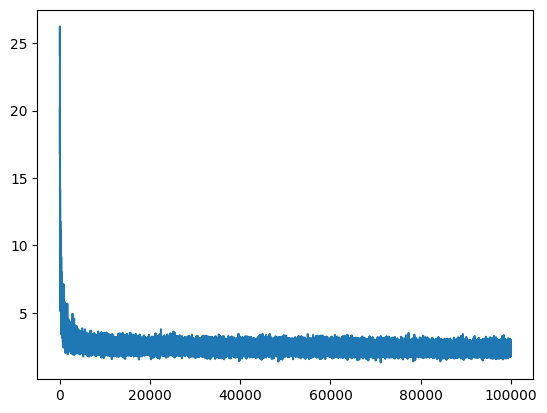

In [44]:
plt.plot(stepsi, lossi)

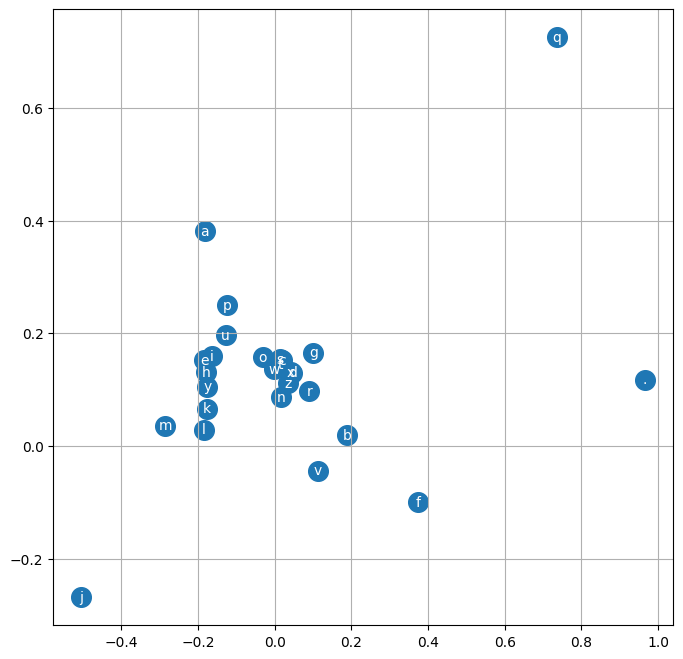

In [39]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')